<a href="https://colab.research.google.com/github/DennisMYoung/Deep_Learning_Final/blob/main/DL_Final_Project_MSDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective

 The open-access archive, **arXiv**, uses category taxinomy to categorize the various articles in the archive.

 Ealier today, I asked ChatGPT how these categories are assigned.  In short, these categories are assigned by the auther from a pre-defined list.  Then, volunteer moderators review the submission and confirm than the categories are appropriate.

 The goal of this project is to train a deep-learning model to categorize the articles.  Such a model could potentially reduce the workload of both the author and the moderator.


##ktrain

The python library 'ktrain' will be used in this project.  Ktrain is a low-code Python library that makes it very easy to train machine learning models.  

Examples, tutorials, documentation can be found at the GitHub repository below.

https://github.com/amaiya/ktrain

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
from ktrain import text # Import the text module from ktrain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset

The dataset that will be used for this project is a curated dataset available on the Kaggle platform: https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset.  This dataset has ~136K records and includes items such as the article title, category, summary of the article, and authors.

There is a large dataset that is also available through Kaggle that contains meta-data on over 1.7M articles: https://www.kaggle.com/datasets/Cornell-University/arxiv


For our puposes, the curated dataset will suffice.  However, depending on the performance of the model, I may explore the larger dataset in the future.





In [ ]:
 arXiv_df = pd.read_csv("/content/drive/MyDrive/Deep_Learning_Final_Project/arXiv_scientific dataset.csv")

The datset contains information on over 100K articles in the archive.

In [ ]:
arXiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136238 entries, 0 to 136237
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  136238 non-null  object
 1   title               136238 non-null  object
 2   category            136238 non-null  object
 3   category_code       136238 non-null  object
 4   published_date      136238 non-null  object
 5   updated_date        136238 non-null  object
 6   authors             136238 non-null  object
 7   first_author        136238 non-null  object
 8   summary             136238 non-null  object
 9   summary_word_count  136238 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 10.4+ MB


##EDA

Looking unique values for 'catgory' and 'category_code', it looks like there is a 'category' that corresponds two 'category_code' values.

In [ ]:
category_counts = arXiv_df['category'].value_counts()
category_counts.info()

<class 'pandas.core.series.Series'>
Index: 138 entries, Machine Learning to History and Philosophy of Physics
Series name: count
Non-Null Count  Dtype
--------------  -----
138 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


In [ ]:
category_cd_counts = arXiv_df['category_code'].value_counts()
category_cd_counts.info()

<class 'pandas.core.series.Series'>
Index: 139 entries, cs.LG to physics.hist-ph
Series name: count
Non-Null Count  Dtype
--------------  -----
139 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


The category 'Numerical Analysis' corresponds to two codes, 'cs.NA' and 'math.NA'.  That is potentially something to be aware of.

In [ ]:
cat_test = arXiv_df[['category','category_code']].drop_duplicates()
cat_grp = cat_test.groupby('category',as_index = False)['category_code'].count()
cat_grp = cat_grp[cat_grp['category_code'] > 1]
cat_grp

,category,category_code
98,Numerical Analysis,2


In [ ]:
cat_test[cat_test['category'] == 'Numerical Analysis']

,category,category_code
39965,Numerical Analysis,cs.NA
40889,Numerical Analysis,math.NA


Looking at the article count by 'category_code' there is a major drop in article count after the top 6 categories.

In [ ]:
category_cd_counts.head(10)

,count
category_code,
cs.LG,39986
cs.CV,29057
cs.CL,25202
cs.AI,12969
stat.ML,10447
cs.NE,5509
cs.RO,903
cs.IR,901
stat.ME,882


After labelling every category outside of the top 6 catgories, in terms of record count, as "Other", the distibution can be seen below.  The data is unbalanced, but I don't want to balance it right now because there is a chance that too many records will be lost.

Axes(0.125,0.11;0.775x0.77)


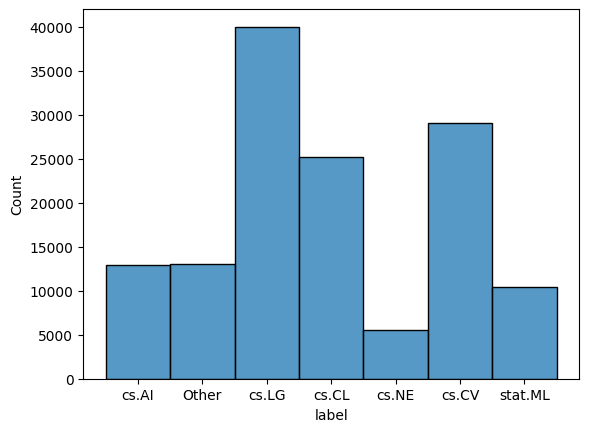

In [ ]:
top_6_categories = category_cd_counts.head(6)
top_6_categories

arXiv_df['label'] = np.where(arXiv_df['category_code'].isin(top_6_categories.index), arXiv_df['category_code'], 'Other')
print(sns.histplot(arXiv_df['label']))

Below is a lookup table to map the 'category_code' to the 'category'.

In [ ]:
lookup = arXiv_df[['label','category']][arXiv_df['label'] != 'Other'].drop_duplicates()
lookup

,label,category
0,cs.AI,Artificial Intelligence
9313,cs.LG,Machine Learning
9318,cs.CL,Computation and Language (Natural Language Pro...
9400,cs.NE,Neural and Evolutionary Computing
9449,cs.CV,Computer Vision and Pattern Recognition
10070,stat.ML,Machine Learning (Statistics)


Now let's look at the distributions of the summary texts.

In [ ]:
arXiv_df['word_count_summary'] = arXiv_df['summary'].apply(lambda x: len(str(x).split()))
arXiv_df['summ_len'] = arXiv_df['summary'].apply(lambda x: len(str(x)))
arXiv_df[['summary','summary_word_count','word_count_summary','summ_len']].head()

,summary,summary_word_count,word_count_summary,summ_len
0,Because of their occasional need to return to ...,79,79,545
1,Market price systems constitute a well-underst...,119,119,876
2,We describe an extensive study of search in GS...,167,167,1075
3,As real logic programmers normally use cut (!)...,174,174,1120
4,To support the goal of allowing users to recor...,187,187,1289


The word count distribution of the summary centered around 150 words.

<Axes: xlabel='word_count_summary', ylabel='Count'>

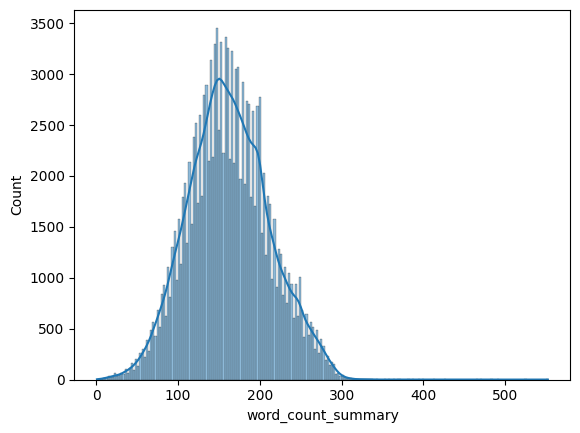

In [ ]:
sns.histplot(arXiv_df['word_count_summary'], kde=True)

The distribution of the length of the summary is centered at a little over 1000.

<Axes: xlabel='summ_len', ylabel='Count'>

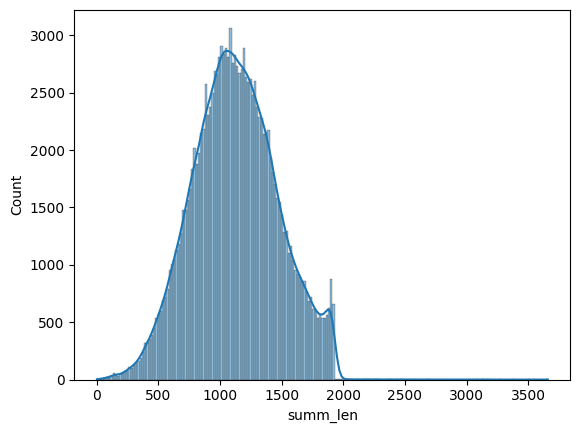

In [ ]:
sns.histplot(arXiv_df['summ_len'], kde=True)

##Train-Test Split

In [ ]:
arXiv_df_train = arXiv_df.sample(frac=0.8, random_state=124)
arXiv_df_test = arXiv_df.drop(arXiv_df_train.index)

arXiv_df_train['text'] = arXiv_df_train['title'] + arXiv_df_train['summary']
arXiv_df_test['text'] = arXiv_df_test['title'] + arXiv_df_test['summary']

arXiv_df_train.shape, arXiv_df_test.shape

((108990, 14), (27248, 14))

In [ ]:
text_train = arXiv_df_train['text'].tolist()
labels_train = arXiv_df_train['label'].values.tolist()

text_test = arXiv_df_test['text'].tolist()
labels_test = arXiv_df_test['label'].values.tolist()

labels_dist = arXiv_df_train['label'].drop_duplicates().values.tolist()
labels_dist

['cs.LG', 'cs.CV', 'Other', 'cs.AI', 'cs.CL', 'cs.NE', 'stat.ML']

#Text Classification Models

## DistilBERT Transformer Model

Bidirectional Encoder Representation from Transformers, or BERT, is a model that works to identify the context of a particular work.  As an example, Google Research mentions that the work "bank" has different meaning when describing the "bank of a river", rather that a place where you store your money.

DistilBERT is a smaller and faster version of BERT.

In a previous project, I had pretty good success with binary classification using a pre-trained DistilBERT model.  Let's see how it does with multi-class classification.

The preprocessing will use distilbert preprocessing mode and classifier.  We set the max length of our text at 170 to speed up training.

In [ ]:
train_model1, val_model1, preprocess_model1 = text.texts_from_array(
    x_train=text_train,
    y_train=labels_train,
    class_names=labels_dist,
    preprocess_mode='distilbert',
    maxlen=170
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessing train...
language: en
train sequence lengths:
	mean : 170
	95percentile : 258
	99percentile : 288


/usr/local/lib/python3.11/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 170
	95percentile : 259
	99percentile : 288


task: text classification


In [ ]:
model = text.text_classifier('distilbert', train_data=train_model1, preproc=preprocess_model1, multilabel=True)

Is Multi-Label? True
maxlen is 170
done.


The architecture of the model is very complex.  However, we do have a summary below with some of the details.

More information is available in https://medium.com/huggingface/distilbert-8cf3380435b5

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_60 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This next step will train the model with different learning rates to help determine the max learning rate for our model.

In [ ]:
learner_model1 = ktrain.get_learner(model, train_data=train_model1, val_data=val_model1, batch_size=64)

In [ ]:
learner_model1.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1532/1532 [==============================] - 1641s 1s/step - loss: 1.5763 - binary_accuracy: 0.8644
Epoch 2/5
1532/1532 [==============================] - 1629s 1s/step - loss: 0.8403 - binary_accuracy: 0.8381
Epoch 3/5
1532/1532 [==============================] - 1624s 1s/step - loss: 1.3098 - binary_accuracy: 0.7767
Epoch 4/5
1532/1532 [==============================] - 1490s 973ms/step - loss: 1.7834 - binary_accuracy: 0.7807
Epoch 5/5
1532/1532 [==============================] - 407s 265ms/step - loss: 413.0753 - binary_accuracy: 0.7438


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


After training the model with different learning rates, it looks like a max learning rate 10^4 is a good choice.

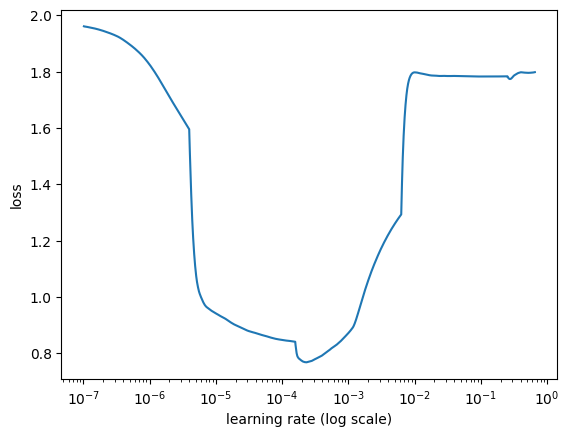

In [ ]:
learner_model1.lr_plot()

In [ ]:
learner_model1.reset_weights(verbose=0)
learner_model1.autofit(
    .0001,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
1533/1533 [==============================] - 1694s 1s/step - loss: 0.8282 - binary_accuracy: 0.8018 - val_loss: 0.6976 - val_binary_accuracy: 0.8067
Epoch 2/10
1533/1533 [==============================] - 1664s 1s/step - loss: 0.6441 - binary_accuracy: 0.8088 - val_loss: 0.6877 - val_binary_accuracy: 0.8103
Epoch 3/10
1533/1533 [==============================] - 1664s 1s/step - loss: 0.5565 - binary_accuracy: 0.8195 - val_loss: 0.6959 - val_binary_accuracy: 0.8110
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
Weights from best epoch have been loaded into model.


Since the data is imbalanced, the macro avg f1-score is probably the most important measure of performance for this model.  The f1-score of 0.66 is about .5.  So, it is classifying the text well.  

In [ ]:
validation_model1 = learner_model1.validate(val_data=val_model1, print_report=True)

341/341 [==============================] - 63s 185ms/step
              precision    recall  f1-score   support

           0       0.54      0.41      0.47      1103
           1       0.72      0.57      0.63      1047
           2       0.85      0.94      0.89      1990
           3       0.88      0.91      0.89      2314
           4       0.69      0.80      0.74      3176
           5       0.65      0.67      0.66       448
           6       0.46      0.28      0.34       821

    accuracy                           0.74     10899
   macro avg       0.68      0.65      0.66     10899
weighted avg       0.73      0.74      0.73     10899



In [ ]:
predictor_model1 = ktrain.get_predictor(learner_model1.model, preprocess_model1)

In [ ]:
predictor_model1.get_classes()

['Other', 'cs.AI', 'cs.CL', 'cs.CV', 'cs.LG', 'cs.NE', 'stat.ML']

##fastText Model

The next model that we will try is a model called
fastText. This algorithm is a mush faster than a deep-learning algorithm is supposed to give similar results.

More information on the algorithm can be found here: https://arxiv.org/pdf/1607.01759

The 'standard' preprossing in ktrain makes everythin lower-case and removes punctuation.  However, it does not remove stop-words.  So, in a future run, I should probably do additional preprossing.

In [ ]:
train_model2, val_model2, preprocess_model2 = text.texts_from_array(
    x_train=text_train,
    y_train=labels_train,
    x_test=None,
    y_test=None,
    preprocess_mode='standard',
    maxlen=150
)

language: en
Word Counts: 169133
Nrows: 98091
98091 train sequences
train sequence lengths:
	mean : 174
	95percentile : 264
	99percentile : 293
x_train shape: (98091,150)
y_train shape: (98091, 7)
Is Multi-Label? False
10899 test sequences
test sequence lengths:
	mean : 173
	95percentile : 262
	99percentile : 294
x_test shape: (10899,150)
y_test shape: (10899, 7)
task: text classification


In [ ]:
model = text.text_classifier('fasttext', train_data=train_model2, preproc=preprocess_model2, multilabel=True)

Is Multi-Label? True
compiling word ID features...
maxlen is 150
done.


Below is summary of the model architecture.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           1280000   
                                                                 
 spatial_dropout1d (Spatial  (None, 150, 64)           0         
 Dropout1D)                                                      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
learner_model2 = ktrain.get_learner(model, train_data=train_model2, val_data=val_model2, batch_size=64)

In [ ]:
learner_model2.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
1533/1533 [==============================] - 8s 5ms/step - loss: 0.8363 - binary_accuracy: 0.5123
Epoch 2/5
1533/1533 [==============================] - 7s 5ms/step - loss: 0.7036 - binary_accuracy: 0.6053
Epoch 3/5
1533/1533 [==============================] - 7s 5ms/step - loss: 0.3546 - binary_accuracy: 0.8611
Epoch 4/5
1533/1533 [==============================] - 7s 5ms/step - loss: 0.3098 - binary_accuracy: 0.8823
Epoch 5/5
1533/1533 [==============================] - 7s 5ms/step - loss: 0.4035 - binary_accuracy: 0.8532


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


This next step will train the model with different learning rates to help determine the max learning rate for our model.



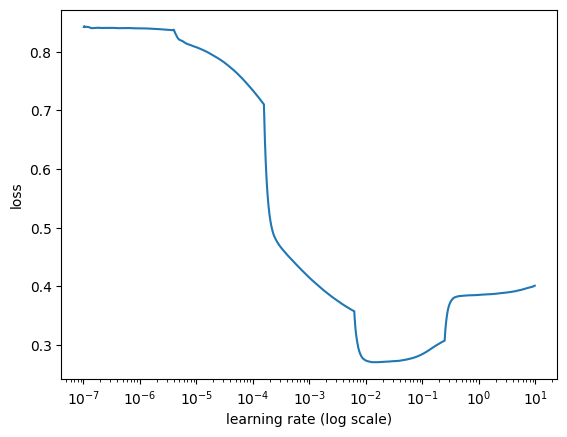

In [ ]:
learner_model2.lr_plot()

From the chart above, the performance gets much worse aroud a learning rate of .1. I will set my maximum learning rate to .01, which had the lowest loss, when training the model.

The autofit method in ktrain employs a triangular learning rate schedule and uses the supplied learning rate as the maximum learning rate.  It includes the 'early_stopping' aurgument, which stops the training when the epoch fails to produce a lower 'val_loss'.

The fit_onecycle method is a nice alternative to the autofit method, that sometimes produces different results.  However, it does not have the 'early_stopping' option.

In [ ]:
learner_model2.autofit(
    .01,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/10
1533/1533 [==============================] - 9s 6ms/step - loss: 0.2998 - binary_accuracy: 0.8815 - val_loss: 0.2166 - val_binary_accuracy: 0.9139
Epoch 2/10
1533/1533 [==============================] - 9s 6ms/step - loss: 0.2388 - binary_accuracy: 0.9057 - val_loss: 0.2062 - val_binary_accuracy: 0.9177
Epoch 3/10
1533/1533 [==============================] - 9s 6ms/step - loss: 0.2281 - binary_accuracy: 0.9105 - val_loss: 0.2023 - val_binary_accuracy: 0.9184
Epoch 4/10
1533/1533 [==============================] - 9s 6ms/step - loss: 0.2200 - binary_accuracy: 0.9135 - val_loss: 0.1987 - val_binary_accuracy: 0.9198
Epoch 5/10
1533/1533 [==============================] - 9s 6ms/step - loss: 0.2138 - binary_accuracy: 0.9162 - val_loss: 0.1966 - val_binary_accuracy: 0.9207
Epoch 6/10
1533/1533 [==============================] - 9s 6ms/step - loss: 0.2079 - binary_accuracy: 0.9182 - val_loss: 0.1960 - va

The Fast-Text algorithm trained with blazing speed, compared to the deep learning algorithm.  However, the F1-score on the validation data is lower accross all categories, compared to the DistilBERT model.

The macro avg. f1-score is .51, well below the 0.66 from the DistilBERT model.

In [ ]:
validation_model2 = learner_model2.validate(val_data=val_model2, print_report=True)

341/341 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1066
           1       0.77      0.40      0.53      1051
           2       0.88      0.87      0.87      2018
           3       0.91      0.84      0.87      2340
           4       0.70      0.66      0.68      3127
           5       0.77      0.43      0.55       456
           6       0.50      0.04      0.07       841

   micro avg       0.81      0.59      0.68     10899
   macro avg       0.65      0.46      0.51     10899
weighted avg       0.70      0.59      0.62     10899
 samples avg       0.59      0.59      0.59     10899



/usr/local/lib/python3.11/dist-packages/ktrain/core.py:226: UserWarning: Confusion matrices do not currently support multilabel classification, so returning None
  warnings.warn(


In [ ]:
predictor_model2 = ktrain.get_predictor(learner_model2.model, preprocess_model2)

In [ ]:
predictor_model2.get_classes()

['Other', 'cs.AI', 'cs.CL', 'cs.CV', 'cs.LG', 'cs.NE', 'stat.ML']

ktrain includes a 'view_top_losses' method that allows us to quickly evaluate our biggest misses from the prediction algorithm.  It looks like the first, third, and fifth results below are about CNNs, and the model incorrectly predicted 'Computer Vision and Pattern Recognition'.  However, given that they are about CNNs, 'Computer Vision and Pattern Recognition' might be a better category than the current category in the archive.  Unfortunately, this option did not work on the DistilBERT model.

In [ ]:
learner_model2.view_top_losses(n=5, preproc=preprocess_model2)

341/341 [==============================] - 0s 1ms/step
----------
id:4751 | loss:2.34 | true:[0. 0. 0. 0. 0. 0. 1.] | pred:[0. 0. 0. 1. 0. 0. 0.])

3d convolutional neural networks for brain tumor segmentation a comparison of multi resolution paper analyzes the use of 3d convolutional neural networks for brain tumor segmentation in mr images we address the problem using three different architectures that combine fine and coarse features to obtain the final segmentation we compare three different networks that use multi resolution features in terms of both design and performance and we show that they improve their single resolution counterparts
----------
id:8585 | loss:2.18 | true:[0. 0. 0. 0. 0. 0. 1.] | pred:[0.01 0.   0.99 0.   0.   0.   0.  ])

using millions of emoji occurrences to learn any domain representations for detecting sentiment emotion and tasks are often limited by scarcity of manually annotated data in social media sentiment analysis and related tasks researchers have 

In [ ]:
predictions_model1 = predictor_model1.predict(text_test)

In [ ]:
predictions_model1[0]

'cs.AI'

In [ ]:
predictions_model2 = predictor_model2.predict(text_test)

In [ ]:
pred_list_model2 = []
for prediction in predictions_model2:
  max_value = 0
  for class_label, prob in prediction:
    if prob > max_value:
      max_value = prob
      preds = class_label
  pred_list_model2.append(preds)

#Evaluation

##DistilBERT model

The results of the DistilBERT model are extremely impressive.  One area where there is room for improvement is in 'Machine Learning (Statistics)'.  A large number of those cases were getting predicted as 'Computer Vision and Pattern Recognition'.  However, when we reviewed the top loss results of the 'Fast-Text' model, there were papers on CNNs that appear to be incorrectly labeled as 'Machine Learning (Statistics)'.  So, it could be the case that the model is working as expected and some of the difference is due to human-error while categorizing the articles.

In [ ]:
con_matrix_model1 = confusion_matrix(labels_test,predictions_model1)

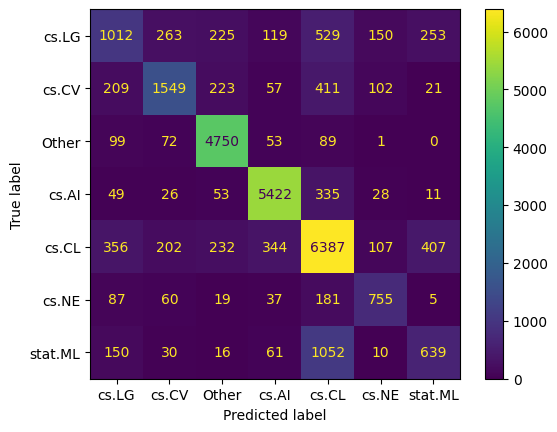

              precision    recall  f1-score   support

       Other       0.52      0.40      0.45      2551
       cs.AI       0.70      0.60      0.65      2572
       cs.CL       0.86      0.94      0.90      5064
       cs.CV       0.89      0.92      0.90      5924
       cs.LG       0.71      0.79      0.75      8035
       cs.NE       0.65      0.66      0.66      1144
     stat.ML       0.48      0.33      0.39      1958

    accuracy                           0.75     27248
   macro avg       0.69      0.66      0.67     27248
weighted avg       0.74      0.75      0.74     27248



In [ ]:
display = ConfusionMatrixDisplay(con_matrix_model1, display_labels=labels_dist)
display.plot()
plt.show()
print(classification_report(labels_test,predictions_model1))

##fastText Model

The DistilBERT model did much better at classifying the articles than the fastText model.  However, given the speed to train and to make predictions, the results from the fastText Model on the testing data are very impressive and appear to be better than the results on the validation data.  The testing data has a weighted average f1-score of 0.68, which is below the 0.74 in from the DistilBERT model.  In fact, the DistilBERT model was better at predicting every category.

One thing that really stands out when reviewing the fastText model results is that it severly underpredicted the 'Machine Learning' category, often predicting 'Computation and Language'.  This is something to research further.
  

In [ ]:
con_matrix_model2 = confusion_matrix(labels_test,pred_list_model2)

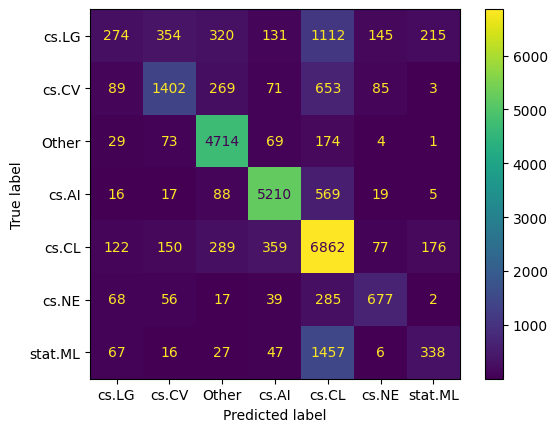

              precision    recall  f1-score   support

       Other       0.41      0.11      0.17      2551
       cs.AI       0.68      0.55      0.60      2572
       cs.CL       0.82      0.93      0.87      5064
       cs.CV       0.88      0.88      0.88      5924
       cs.LG       0.62      0.85      0.72      8035
       cs.NE       0.67      0.59      0.63      1144
     stat.ML       0.46      0.17      0.25      1958

    accuracy                           0.71     27248
   macro avg       0.65      0.58      0.59     27248
weighted avg       0.69      0.71      0.68     27248



In [ ]:
display = ConfusionMatrixDisplay(con_matrix_model2, display_labels=labels_dist)
display.plot()
plt.show()
print(classification_report(labels_test,pred_list_model2))

##Prediction for this Notebook

Just for fun.  Let's see what the models would categorize this report using the description in the 'Objective' section.

Both models categorized this report as 'Computation and Language', which I think is the most applicable category.

In [ ]:
predictor_model1.predict(" The open-access archive, arXiv, uses category taxinomy to categorize the various articles in the archive. Ealier today, I asked ChatGPT how these categories are assigned.  In short, these categories are assigned by the auther from a pre-defined list.  Then, volunteer moderators review the submission and confirm than the categories are appropriate.The goal of this project is to train a deep-learning model to categorize the articles.  Such a model could potentially reduce the workload of both the author and the moderator.")

'cs.CL'

In [ ]:
predictor_model2.predict(" The open-access archive, arXiv, uses category taxinomy to categorize the various articles in the archive. Ealier today, I asked ChatGPT how these categories are assigned.  In short, these categories are assigned by the auther from a pre-defined list.  Then, volunteer moderators review the submission and confirm than the categories are appropriate.The goal of this project is to train a deep-learning model to categorize the articles.  Such a model could potentially reduce the workload of both the author and the moderator.")

[('Other', 0.17225325),
 ('cs.AI', 0.120194845),
 ('cs.CL', 0.50773394),
 ('cs.CV', 0.009920702),
 ('cs.LG', 0.07080246),
 ('cs.NE', 0.009495664),
 ('stat.ML', 0.008632813)]

#Conclusion

This was a very educational project, as it was my first attempt multi-class classification using deep-learning.  Overall, I now have two very good models for classifying articles in arXiv.  In fact, my early investigations show that it is actually helpful for identifying articles that are currently mis-categorized in the archive.

The DistilBERT model performed very well, but it tool a very long time to train and make predictions.  For next run, I will likely limit the number of parameters, which should speed-up the process.  

While it is not a deep-learning model, this project made me fascinated by the fastText algorithm.  The performance was not as good as the deep-learning algorithm, but it had good performance with blazing fast-speeds.  Since the model was preprossed using the 'standard' pre-processing in the ktrain library, which does not remove stop-words, I would like to add some additonal pre-processing steps to see if it improves the predictions.  I would also like to investigate why it under-predicted the "Machine Learning" category.  This will require more details investigations into the data.

One issue with the model, is that it currently only works to categories the six main categories related to machine learning, but there are several more categories for the archive.  The long list of potential categories makes evaluation more difficult and would require additonal data.  The data used for this model was only a subset of the available data.  On the Kaggle platform there is meta-data on over 1.7M articles, which can be used for a more robust model.

Also, the data was unbalanced.  It is possible that training the models on balanced data will produce better results.

##References

Maiya, Arun, 2020, “ktrain: A Low-Code Library for Augmented Machine Learning” (GitHub: https://github.com/amaiya/ktrain)

Mishra, Sumit, 2025, "arXiv Scientific Research Papers Dataset": https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset

Devlin, Jacob and Chang, Ming-Wei, 2018, “Open Sourcing BERT: State-of-the-Art Pre-training for Natural Language Processing":
https://research.google/blog/open-sourcing-bert-state-of-the-art-pre-training-for-natural-language-processing/

Joulin, Armand; Grave, Edouard; Piotr, Grave; Bojanowski, Pioter; Mikolov, Tomas, 2016, "Bag of Tricks for Efficient Text Classification": https://arxiv.org/pdf/1607.01759

Sahn, Victor, 2019, "Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT": https://medium.com/huggingface/distilbert-8cf3380435b5